### Style Transfer

The Gatys Style Transfer

* From [this very paper](https://arxiv.org/abs/1508.06576)
* Though GAN is better for the task recently, but this style transfer is a good exercise

In [2]:
from torchvision.models.vgg import vgg16_bn

In [3]:
vgg_model = vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /Users/salvor/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [03:52<00:00, 2378638.99it/s]


### Check The Model Structure

In [145]:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

### Establish Learnable Image

In [146]:
from torch import nn
import torch

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [194]:
def get_img():return nn.Parameter(data = torch.rand(1,120,160,3),)
img = get_img()

In [148]:
def param_2_npimg(img):
    img_np = img.data.numpy()
    return np.squeeze(img_np,axis=0)

def show_img(img):
    return plt.imshow(param_2_npimg(img))

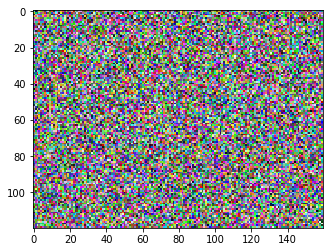

In [149]:
show_img(img)

#### Check Target Image

In [150]:
from PIL import Image

In [151]:
target = Image.open("target.jpg")

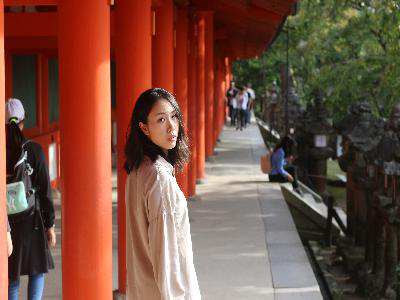

In [152]:
target

In [153]:
target_arr = torch.FloatTensor(np.expand_dims(np.array(target.resize((160,120))),axis=0))/255
print(target_arr.size())

torch.Size([1, 120, 160, 3])


In [154]:
target_arr

tensor([[[[0.8784, 0.3961, 0.2314],
          [0.6667, 0.2000, 0.0824],
          [0.5882, 0.0941, 0.0392],
          ...,
          [0.5765, 0.6078, 0.4549],
          [0.3843, 0.4431, 0.2824],
          [0.3216, 0.3961, 0.2196]],

         [[0.8902, 0.3608, 0.1843],
          [0.7255, 0.2431, 0.1137],
          [0.5490, 0.1137, 0.0392],
          ...,
          [0.4902, 0.5176, 0.3529],
          [0.3922, 0.4392, 0.2980],
          [0.3216, 0.3804, 0.2510]],

         [[0.9059, 0.3490, 0.2000],
          [0.7412, 0.2941, 0.1882],
          [0.3176, 0.0392, 0.0000],
          ...,
          [0.4549, 0.4824, 0.2824],
          [0.5020, 0.5373, 0.4157],
          [0.4157, 0.4510, 0.3843]],

         ...,

         [[1.0000, 0.6941, 0.5882],
          [0.9804, 0.7176, 0.6431],
          [1.0000, 0.6863, 0.5529],
          ...,
          [0.2627, 0.2510, 0.2314],
          [0.1176, 0.1137, 0.0941],
          [0.0902, 0.0863, 0.0667]],

         [[1.0000, 0.6706, 0.5608],
          [0.9608

#### Optimizer

In [155]:
from torch.optim import Adam

In [185]:
from forgebox.ftorch import FG

In [186]:
fg = FG("style_transfer")

==========hyper params==========
{}


In [188]:
p = fg.p

In [156]:
opt = Adam([img],)

#### Learning The Image

Empty dataset

In [157]:
from torch.utils.data.dataset import Dataset
class empty(Dataset):
    def __init__(self,length):
        self.length = length
        self.seq = np.random.rand(length,2)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        return self.seq[idx]

In [158]:
from forgebox.ftorch.train import Trainer

In [189]:
trainer = Trainer(empty(p("iterlen",100)),batch_size=1,shuffle=False, print_on=2)

In [190]:
loss_func = nn.MSELoss()

In [195]:
@trainer.step_train
def action(*args,**kwargs):
    opt.zero_grad()
    loss = loss_func(img,target_arr)
    loss.backward()
    opt.step()
    return {"loss":loss.item()}

In [200]:
img = get_img()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


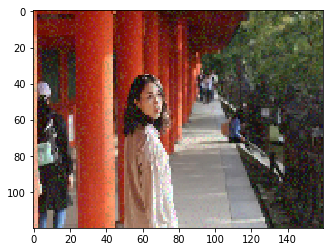

In [201]:
opt = Adam([img],)
trainer.train(p("origin_recon_epochs",10))
show_img(img)

### Content Reconstruction

In [202]:
conv2blocks = vgg_model.features[:14]
conv2blocks

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [203]:
def torch_shape(img):
    """
    Swap the dimensions for python is bs,h,w,c, but the image we opened is bs,c,h,w
    """
    return img.permute(0,3,1,2)

In [204]:
img = nn.Parameter(data = torch.rand(1,120,160,3),)
opt = Adam([img],)
@trainer.step_train
def action(*args,**kwargs):
    opt.zero_grad()
    rep1 = conv2blocks(torch_shape(img))
    rep2 = conv2blocks(torch_shape(target_arr))
    loss = loss_func(rep1,rep2)
    loss.backward()
    opt.step()
        
    return {"loss":loss.item()}

In [205]:
img = get_img()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


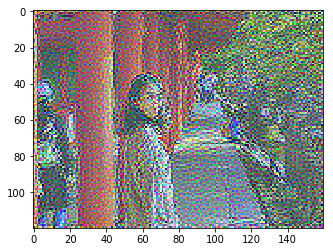

In [206]:
opt = Adam([img],)
trainer.train(p("content_recon_epochs",10))
show_img(img)